# Import Packages and Define Utility Functions

In [9]:
%env MUJOCO_GL=egl

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

from dm_control import composer
from dm_control import mujoco
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML

%matplotlib widget

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

env: MUJOCO_GL=egl


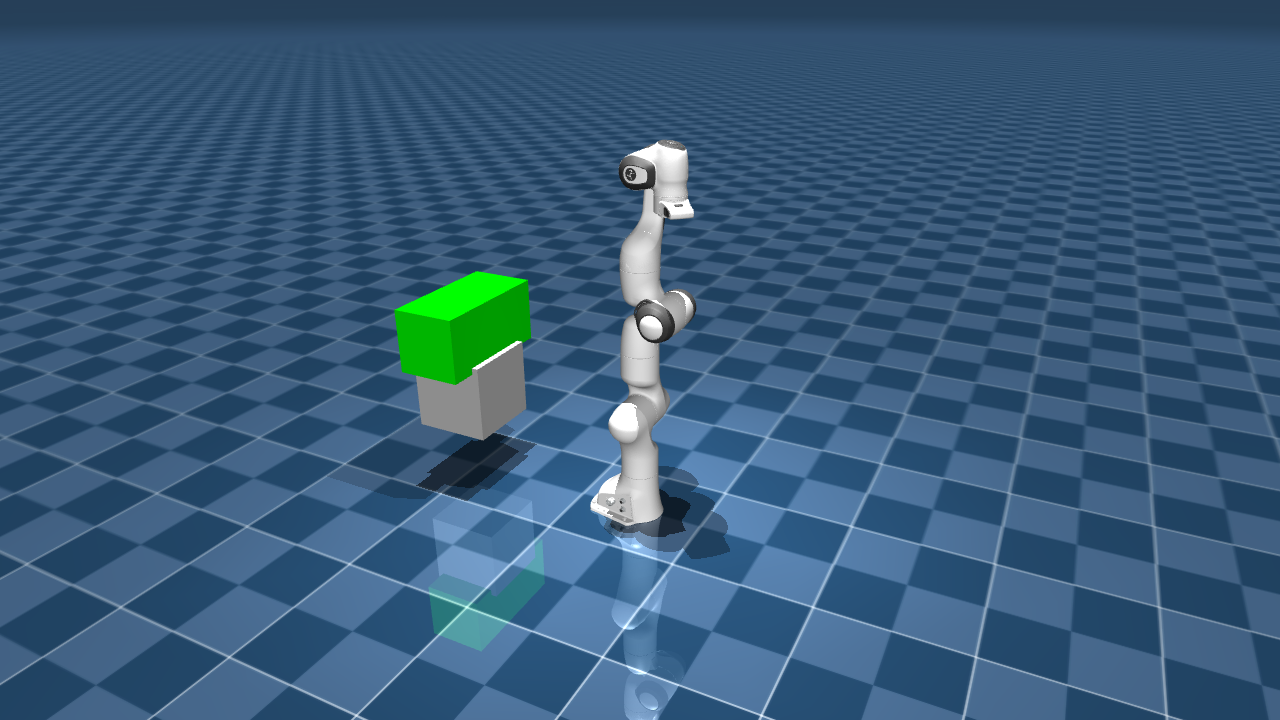

In [63]:
# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-12

scene_xml = 'models/scene.xml'
site_name = 'attachment_site'

physics = mujoco.Physics.from_xml_path(scene_xml)
target_pos = physics.named.data.site_xpos[site_name]

result = ik.qpos_from_site_pose(
          physics=physics,
          site_name=site_name,
          target_pos=target_pos,
          #target_quat=target_quat,
          joint_names=joint_names,
          tol=_TOL,
          max_steps=_MAX_STEPS,
          inplace=True,
      )

pixels = physics.render(width=1280, height=720, camera_id='prospective')
PIL.Image.fromarray(pixels)

In [77]:
duration = 5.0 # (Seconds)
framerate = 24  # (Hz)
video = []

# Simulate, saving video frames
physics.reset()
time = 0.0
s = 1
while physics.data.time < duration:
    s *= -1
    # Inject controls and step the physics.
    physics.set_control(np.random.rand((7)))
    physics.step()

    # Save video frames.
    if len(video) < physics.data.time * framerate:
        pixels = physics.render(width=1280, height=720, camera_id='prospective')
        video.append(pixels.copy())

display_video(video, framerate)